# Code to generate final graphs for Stage 2 results

## Imports

In [3]:
import timm
import torch
import torchvision
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import json
import numpy as np
import sys
import os
from tqdm import tqdm
import pandas as pd
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
sys.path.append('/home/21576262@su/masters/')
from src.data.get_data import get_her2test_dataloader
from src.models.inception_model import InceptionV3

In [20]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amsfonts}'

sns.set(font='Franklin Gothic Book',
        rc={
            'text.usetex': True,
            'font.family': 'serif',
            'text.latex.preamble': [r'\usepackage{amsmath}', r'\usepackage{amsfonts}'],
            'axes.axisbelow': False,
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'black',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'black',
            'xtick.bottom': False,
            'xtick.color': 'black',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'black',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":18,
                                "axes.labelsize":14})


## Functions

In [4]:
def define_colours():
    M_darkpurple = '#783CBB'
    M_lightpurple = '#A385DB'
    M_green = '#0a888a'
    M_yellow = '#FFDD99'
    M_lightpink = '#EFA9CD'
    M_darkpink = '#E953AD'

    colour_list = [M_lightpink, M_green, M_darkpurple, M_darkpink, M_lightpurple, M_yellow]
    cd = {'lightpink': M_lightpink, 'lightpurple': M_lightpurple, 'green': M_green, 'purple': M_darkpurple, 'pink': M_darkpink, 'yellow': M_yellow}
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour_list)
    
    # Create custom gradient colourmap
    rgb_tuples =[(255, 255, 255),(249, 251, 251),(243, 247, 246),(237, 242, 242),(231, 238, 238),
                 (225, 234, 234),(219, 230, 230),(213, 226, 225),(207, 221, 221),(202, 217, 217),
                 (196, 213, 213),(190, 209, 209),(184, 205, 205),(178, 201, 201),(172, 197, 196),
                 (167, 193, 192),(161, 188, 188),(155, 184, 184),(149, 180, 180),(144, 176, 176),
                 (138, 172, 172),(132, 168, 168),(126, 164, 164),(121, 160, 160),(115, 157, 156),
                 (109, 153, 153),(103, 149, 149),(98, 145, 145),(92, 141, 141),(86, 137, 137),
                 (80, 133, 133),(74, 129, 130),(68, 125, 126),(61, 122, 122),(55, 118, 118),
                 (48, 114, 115),(41, 110, 111),(33, 106, 107),(24, 103, 104),(11, 99, 100)]
    # Normalize RGB color values to the range [0, 1]
    normalised_colours = [[r / 255, g / 255, b / 255] for r, g, b in rgb_tuples]
    custom_grn = LinearSegmentedColormap.from_list('Grn', normalised_colours, N=len(normalised_colours))
    
    return cd, custom_grn

def load_trained_models(num_classes, model_path, model_architecture):
    
    model_names = ['RESNET34', 'RESNET18', 'RESNET50', 'INCEPTIONv3', 'INCEPTIONv4', 'INCEPTIONRESNETv2']
    
    if model_architecture == 'RESNET34':
        model = models.resnet34()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_architecture == 'RESNET18':
        model = models.resnet18()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_architecture == 'RESNET50':
        model = models.resnet50()  
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_architecture == 'INCEPTIONv3':
        model = InceptionV3(num_classes=num_classes)
    elif model_architecture == 'INCEPTIONv4':
        model = timm.create_model('inception_v4', pretrained=False, num_classes=num_classes) 
        model.classif = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.7),
            nn.Linear(model.get_classifier().in_features, num_classes)
        )
    elif model_architecture == 'INCEPTIONRESNETv2':
        model = timm.create_model('inception_resnet_v2', pretrained=False, num_classes=num_classes)
        model.classif = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.7),
            nn.Linear(model.get_classifier().in_features, num_classes)
        )
    model.load_state_dict(torch.load(model_path))
    model.eval()

    return model 

### Load trained models

In [28]:
all_models = {'spring-pyramid-177': 'ResNet34', 'trim-valley-173': 'Inception-v4', 'drawn-serenity-176': 'Inception-v3', 'dazzling-sea-175' : 'InceptionResNet-v2'}

In [7]:
json_path1 = '/home/21576262@su/masters/reports/results/stage2_final_patch_results.json'
with open(json_path1, 'r') as file:
            data_patches = json.load(file)
        
json_path2 = '/home/21576262@su/masters/reports/results/stage2_final_slide_results.json'
with open(json_path2, 'r') as file:
            data_slides = json.load(file)

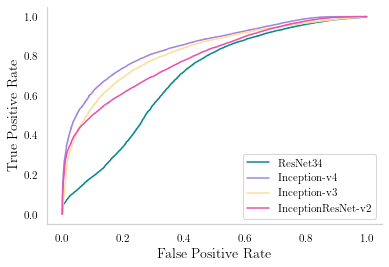

In [84]:
cd, custom_grn = define_colours()

colours = [cd['green'],cd['lightpurple'], cd['yellow'], cd['pink']]
# colours = [cd['green'],cd['lightpurple'], '#3b599c', cd['yellow'], cd['pink']]

plt.figure()
for i, d in enumerate(data_patches):
    model_name = d['model_name']
    
    true_labels = d['true_labels']
    model_probabilities = d['predicted_probs']
    # predicted_classes = d['predicted_classes']
    # agg_probs = d['aggregated_slide_probs']
    # probs2 = d['%_tiles_classified_positive']
    predicted_probs = [model_probabilities[i][1] for i in range(len(model_probabilities))]
    
    #AUC
    auc_score = roc_auc_score(true_labels, predicted_probs)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    # fpr2, tpr2, _ = roc_curve(true_labels, probs2)
    ns_probs = [0 for _ in range(len(true_labels))]
    plt.plot(fpr, tpr, color=colours[i], label=f"{all_models[model_name]}")
    # plt.plot(fpr2, tpr2, linestyle='--', color=colours[i])
    
# ns_fpr, ns_tpr, _ = roc_curve(true_labels, ns_probs)
# plt.plot(ns_fpr, ns_tpr, color=cd['green'], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend()
# plt.show()

# plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "stage2_slide_rocs" + ".eps", format="eps", bbox_inches='tight')   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


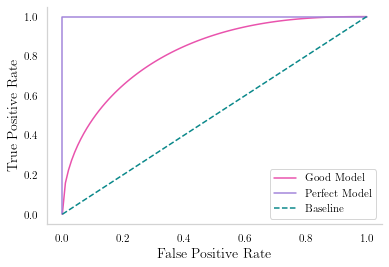

In [96]:
# Hypothetical 'good' ROC curve points
fpr_good = np.linspace(0, 1, 100)
tpr_good = np.sqrt(1 - (1 - fpr_good)**2.5) 

# Perfect ROC curve points
fpr_perfect = [0, 0, 1]
tpr_perfect = [0, 1, 1]

# Plotting the 'good' ROC curve
plt.plot(fpr_good, tpr_good, color=cd['pink'], label='Good Model')

# Plotting the 'perfect' ROC curve
plt.plot(fpr_perfect, tpr_perfect, color=cd['lightpurple'], linestyle='-', label='Perfect Model')

# Plotting the baseline (no-skill classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color=cd['green'], label='Baseline')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.show()
# plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "perfect_roc" + ".eps", format="eps", bbox_inches='tight')   

spring-pyramid-177: 0.898499987571195
trim-valley-173: 0.8645277724225092
drawn-serenity-176: 0.7991118429737354
dazzling-sea-175: 0.8570269032652933


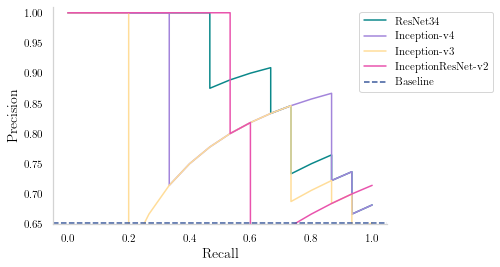

<Figure size 432x288 with 0 Axes>

In [72]:
fig, ax = plt.subplots()
for i, d in enumerate(data_slides):
    model_name = d['model_name']
    
    true_labels = d['true_labels']
    # model_probabilities = d['predicted_probs']
    # predicted_probs = [model_probabilities[i][1] for i in range(len(model_probabilities))]
    
    # predicted_classes = d['predicted_classes']
    agg_probs = d['aggregated_slide_probs']
    # probs2 = d['%_tiles_classified_positive']
    
    pr_auc = average_precision_score(true_labels, agg_probs)
    print(f"{model_name}: {pr_auc}")
    
    precision, recall, thresholds = precision_recall_curve(true_labels, agg_probs)
    
    ax.plot(recall, precision, color=colours[i], label=f"{all_models[model_name]}")
    
    # recall_vertical = [1, 1]
    # precision_vertical = [0.5, 1]
    # plt.plot(recall_vertical, precision_vertical, '-', label='Perfect Model', color=cd['lightpurple'])
    # plt.plot([1, 1], '.', color=cd['lightpurple'])
    # plt.plot([1, 0.5], '.', color=cd['lightpurple'])
    # plt.plot([0, 1], '.', color=cd['lightpurple'])
    
no_skill_precision = np.sum(true_labels) / len(true_labels)
# Add the baseline (no-skill line) to the plot
ax.axhline(y=no_skill_precision, color='#3b599c', linestyle='--', label='Baseline')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.ylim([0.65, 1.01])
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.show()

# plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "stage2_slide_pr_curves" + ".eps", format="eps", bbox_inches='tight')   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


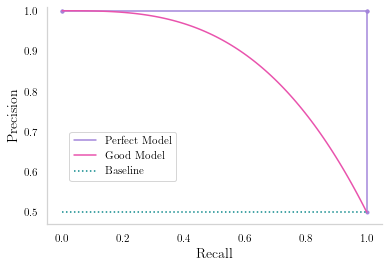

In [127]:
# Create more points for a smoother 'good' PR curve
# recall_good = np.linspace(0, 1, 100)
# precision_good = 1 - (recall_good**3)

# recall_good = np.linspace(0, 1, 100)
# precision_good = (1 - recall_good) ** 2

recall_good = np.linspace(0, 1, 100)
precision_good = 1 - (0.5 * recall_good ** 3)

# Baseline PR curve (assuming a constant proportion of positive instances, e.g., 0.5)
recall_baseline = np.linspace(0, 1, 100)
precision_baseline = np.full_like(recall_baseline, 0.5)  # Change 0.5 based on positive class proportion

recall_vertical = [1, 1]
precision_vertical = [0.5, 1]
plt.plot(recall_vertical, precision_vertical, '-', label='Perfect Model', color=cd['lightpurple'])
plt.plot([1, 1], '.', color=cd['lightpurple'])
plt.plot([1, 0.5], '.', color=cd['lightpurple'])
plt.plot([0, 1], '.', color=cd['lightpurple'])
recall_perfect = np.linspace(0, 1, 100)
precision_perfect = np.ones_like(recall_perfect)
plt.plot(recall_perfect, precision_perfect, color=cd['lightpurple'])

# Plotting the PR curves
plt.plot(recall_good, precision_good, color=cd['pink'], label='Good Model')
# plt.plot(recall_perfect, precision_perfect, color=cd['lightpurple'], linestyle='-', label='Perfect Model')
plt.plot(recall_baseline, precision_baseline, linestyle=':', color=cd['green'], label='Baseline')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.47, 1.01])
plt.legend(loc='upper left', bbox_to_anchor=(0.05, 0.45))

# plt.show()

# plt.savefig("/home/21576262@su/masters/reports/data figs/final/" + "perfect_pr" + ".eps", format="eps", bbox_inches='tight')
